In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DP-CV Colab Notebook /Project/Input/Movies-Poster_Dataset/train.csv')
df.shape

(7254, 27)

In [ ]:
img_folder = '/content/drive/MyDrive/DP-CV Colab Notebook /Project/Input/Movies-Poster_Dataset/Images/'

In [ ]:
class ImageDataset(Dataset):
  
  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    
    self.image_names=self.csv[:]['Id']
    self.labels=np.array(self.csv.drop(['Id', 'Genre'], axis=1))
  
  def __len__(self):
    return len(self.image_names)

  def __getitem__(self,index):
    
    image=cv2.imread(self.img_folder+self.image_names.iloc[index]+'.jpg')
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    image=self.transform(image)
    targets=self.labels[index]

    return (image,targets)

In [ ]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(df,test_size=0.15)

In [ ]:
len(train_set)

6165

In [ ]:
len(test_set)

1089

In [ ]:
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((350, 350)),
                transforms.ToTensor()])

test_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((350, 350)),
                transforms.ToTensor()])

train_dataset=ImageDataset(train_set,img_folder,train_transform)
test_dataset=ImageDataset(test_set,img_folder,test_transform)

In [ ]:
img,labels = train_dataset.__getitem__(0)  #FOR PREVIEW - 2119 in TEST_DATASET(may change depending on splitting)
print(img.shape, labels)

torch.Size([3, 350, 350]) [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [ ]:
num_classes = 25
batch_size = 33

In [ ]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
df

Id                                Genre  ...  War  Western
0     tt0086425                  ['Comedy', 'Drama']  ...    0        0
1     tt0085549        ['Drama', 'Romance', 'Music']  ...    0        0
2     tt0086465                           ['Comedy']  ...    0        0
3     tt0086567               ['Sci-Fi', 'Thriller']  ...    0        0
4     tt0086034  ['Action', 'Adventure', 'Thriller']  ...    0        0
...         ...                                  ...  ...  ...      ...
7249  tt2409818      ['Action', 'Crime', 'Thriller']  ...    0        0
7250  tt2062622    ['Animation', 'Comedy', 'Family']  ...    0        0
7251  tt2442502                           ['Comedy']  ...    0        0
7252  tt3455850                      ['Documentary']  ...    0        0
7253  tt4179482                        ['Animation']  ...    0        0

[7254 rows x 27 columns]

In [ ]:
df_copy = df
image_dict = df_copy.drop(['Id', 'Genre'], axis=1)

In [ ]:
d = {}

i = 0
for gen in image_dict.columns:

  d[i] = gen
  i+=1

In [ ]:
d

{0: 'Action',
 1: 'Adventure',
 2: 'Animation',
 3: 'Biography',
 4: 'Comedy',
 5: 'Crime',
 6: 'Documentary',
 7: 'Drama',
 8: 'Family',
 9: 'Fantasy',
 10: 'History',
 11: 'Horror',
 12: 'Music',
 13: 'Musical',
 14: 'Mystery',
 15: 'N/A',
 16: 'News',
 17: 'Reality-TV',
 18: 'Romance',
 19: 'Sci-Fi',
 20: 'Short',
 21: 'Sport',
 22: 'Thriller',
 23: 'War',
 24: 'Western'}

In [ ]:
dataiter = iter(train_dataloader)
images,targets = dataiter.next()

In [ ]:
print(images.shape)

torch.Size([33, 3, 350, 350])


In [ ]:
print(images[1].shape)

torch.Size([3, 350, 350])


In [ ]:
print(targets[0])

tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


Drama
Romance


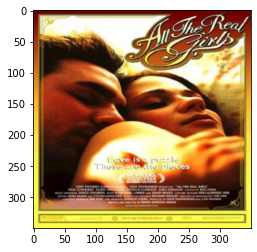

In [ ]:
def show_example(img, label,d):

    for index in range(len(labels)):

      if(labels[index]==1):
        print(d[index])
        
    plt.imshow(img.permute(1, 2, 0))
  
show_example(img,labels,d)

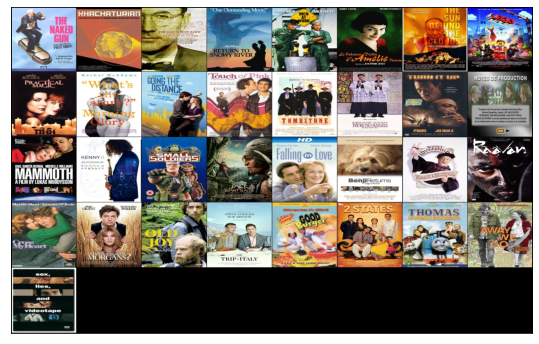

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dataloader)

In [ ]:
from torchvision import models
import torch.nn as nn
import copy

In [ ]:
 vgg= models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([25, 4096])
torch.Size([25])


In [ ]:
vgg = vgg.to(device)
opt = optim.Adam(vgg.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

In [ ]:
print(len(test_dataset))

1089


In [ ]:
def evaluation(dataloader, model):
    
    total, correct = 0, 0
    count = 0
    
    for data in dataloader:
        
        count+=1

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)

        kvals, kidx = outputs.topk(3, dim=1)
        outputs.zero_()
        outputs[torch.arange(outputs.size(0))[:, None], kidx] = 1
        
        #print("PREDICTED OUTPUTS: ",outputs)
        #print("LABELS :", labels)


        for i,j in zip(outputs,labels):
          
          for x in range(len(i)):
            
            if(j[x]==1):
              total+=1

              if(i[x]==1 and j[x]==1):
                correct += 1

          #print ("PRED:",(i == 1).nonzero(as_tuple=True)[0])
          #print ("LABEL:",(j == 1).nonzero(as_tuple=True)[0])
          
        #print("DEBUG:",100*correct/total)
        
        #total += labels.size(0)
        #correct += (outputs == labels).sum().item()
    
    print("CORRECT:",correct)
    print("TOTAL:",total)
    return (100*correct/total)

CORRECT: 1300
TOTAL: 2528
CORRECT: 7546
TOTAL: 14346
Epoch: 0/20, Test acc: 51.42, Train acc: 52.60
CORRECT: 1364
TOTAL: 2528
CORRECT: 7974
TOTAL: 14346
Epoch: 1/20, Test acc: 53.96, Train acc: 55.58
CORRECT: 1389
TOTAL: 2528
CORRECT: 8134
TOTAL: 14346
Epoch: 2/20, Test acc: 54.94, Train acc: 56.70
CORRECT: 1403
TOTAL: 2528
CORRECT: 8271
TOTAL: 14346
Epoch: 3/20, Test acc: 55.50, Train acc: 57.65
CORRECT: 1394
TOTAL: 2528
CORRECT: 8310
TOTAL: 14346
Epoch: 4/20, Test acc: 55.14, Train acc: 57.93
CORRECT: 1386
TOTAL: 2528
CORRECT: 8321
TOTAL: 14346
Epoch: 5/20, Test acc: 54.83, Train acc: 58.00
CORRECT: 1398
TOTAL: 2528
CORRECT: 8435
TOTAL: 14346
Epoch: 6/20, Test acc: 55.30, Train acc: 58.80
CORRECT: 1419
TOTAL: 2528
CORRECT: 8452
TOTAL: 14346
Epoch: 7/20, Test acc: 56.13, Train acc: 58.92
CORRECT: 1399
TOTAL: 2528
CORRECT: 8479
TOTAL: 14346
Epoch: 8/20, Test acc: 55.34, Train acc: 59.10
CORRECT: 1407
TOTAL: 2528
CORRECT: 8545
TOTAL: 14346
Epoch: 9/20, Test acc: 55.66, Train acc: 59.56


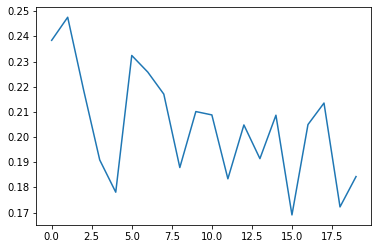

In [ ]:
loss_arr = []
loss_epoch_arr = []
max_epochs = 20

min_loss = 1000

n_iters = np.ceil(len(train_dataset)/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        outputs = torch.sigmoid(outputs)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            
            loss_arr.append(min_loss)
        
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(test_dataloader, vgg), evaluation(train_dataloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

#if i % 100 == 0:
            #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
#print('Min loss %0.2f' % min_loss)          

In [ ]:
genres = df.columns.values[2:]
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

In [ ]:
checker_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=True
)

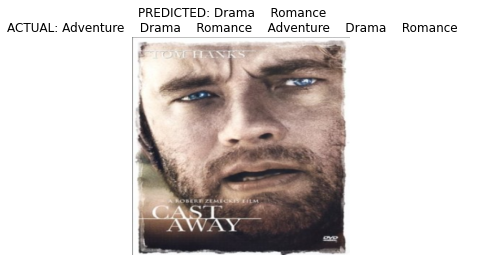

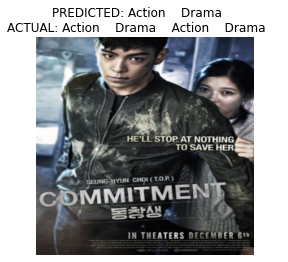

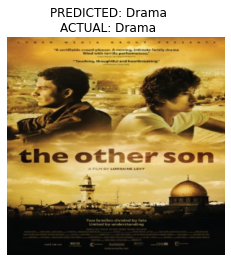

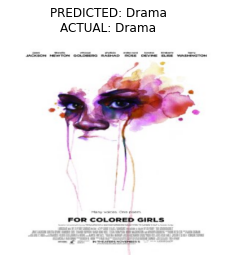

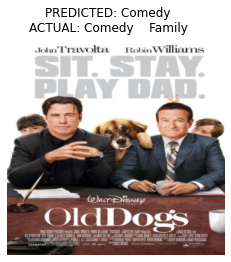

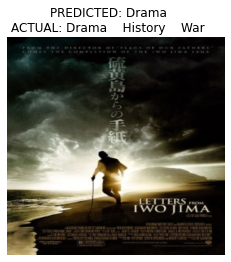

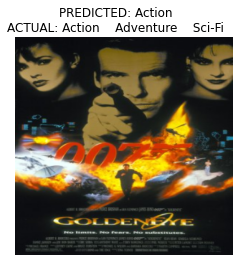

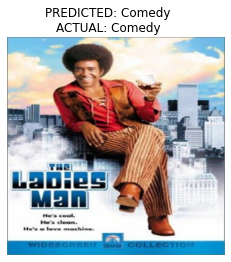

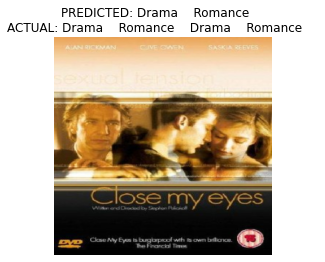

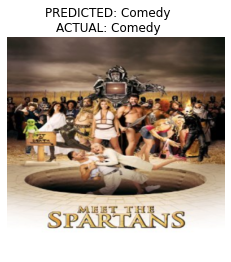

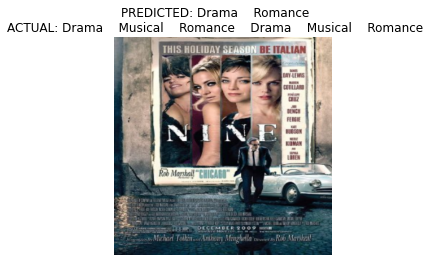

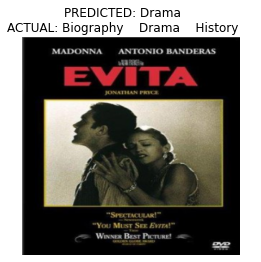

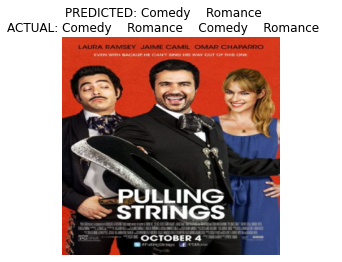

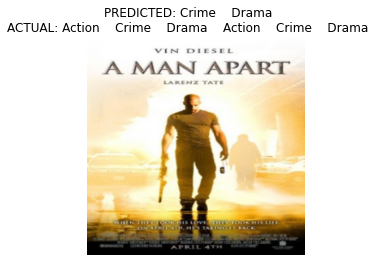

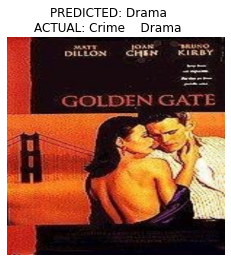

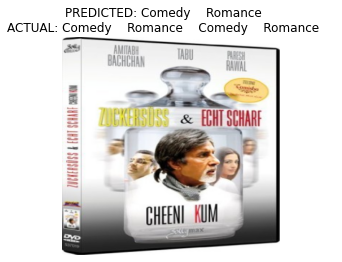

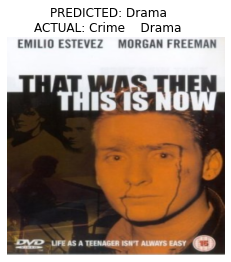

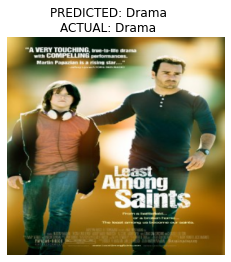

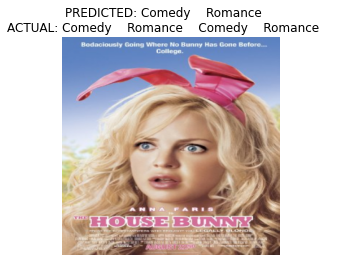

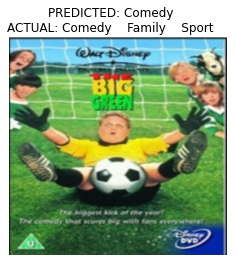

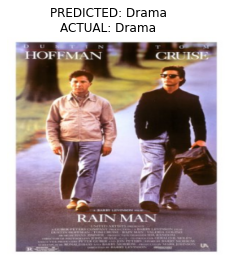

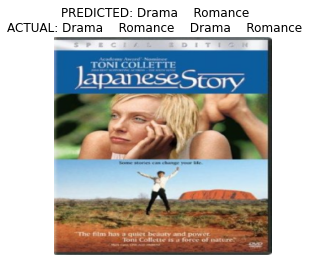

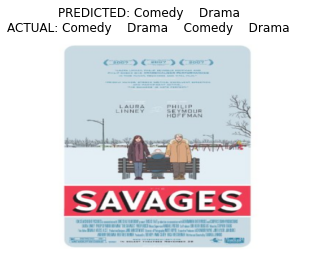

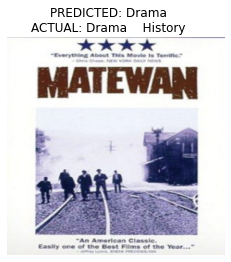

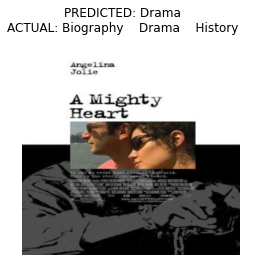

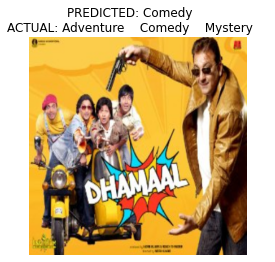

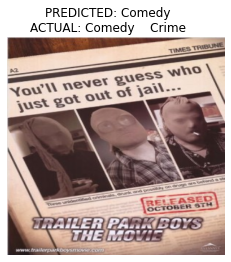

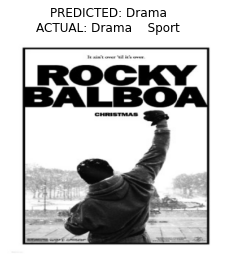

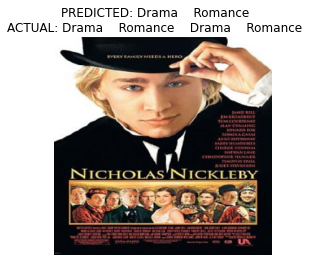

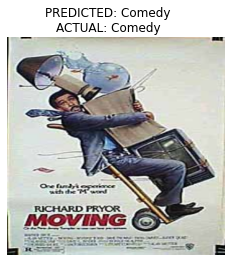

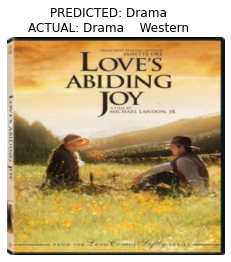

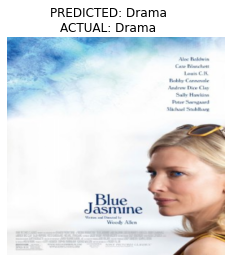

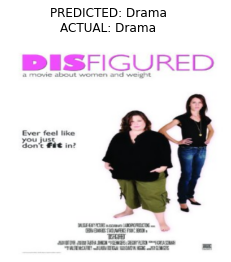

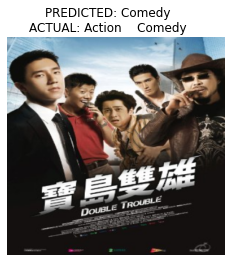

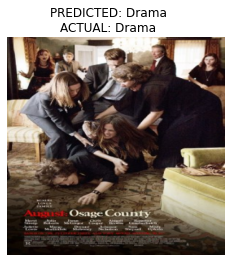

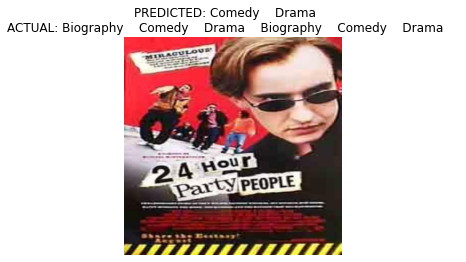

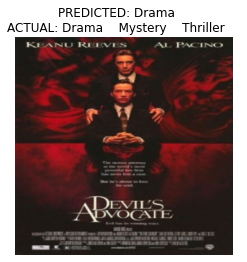

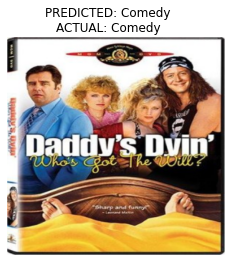

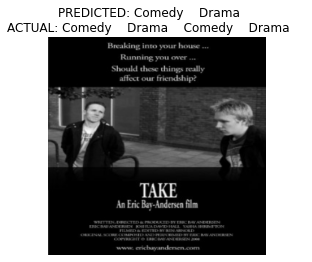

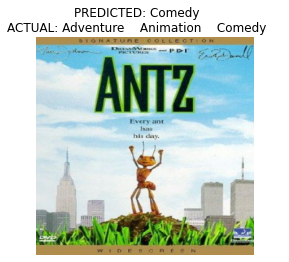

In [ ]:
counter = 0

for counter, data in enumerate(checker_dataloader):

    if(counter == 50):
      break

      counter+=1

    image, target = data
    image, target = image.to(device), target.to(device)

    outputs = vgg(image)
    outputs = torch.sigmoid(outputs)

    kvals, kidx = outputs.topk(3, dim=1)
    outputs.zero_()
    outputs[torch.arange(outputs.size(0))[:, None], kidx] = 1

    for i,j in zip(outputs,target):

      string_predicted = ''
      string_actual = ''
      flg = 0
      
      for x in range(len(i)):
        
        if(i[x]==1):

          if(j[x]==1):

            for k in range(len(j)):
              if(j[k] == 1):
                string_actual += f"{genres[k]}    "
            
            string_predicted += f"{genres[x]}    "
            flg = 1

      if(flg == 1):

        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)

        plt.axis('off')
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        #plt.savefig(f"../outputs/inference_{counter}.jpg")
        plt.show()